In [85]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

using StatsBase

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [132]:
# dataset = "contact-primary-school-classes"
dataset = "congress-bills"
# dataset = "walmart-trips"
# dataset = "TrivagoClickout"
kmax_ = 20

H, Z = read_hypergraph_data(dataset,kmax_)
α = zeros(2*kmax_);

kmax = maximum(keys(H.E))
kmin = minimum(keys(H.E))

n = length(H.D)

# all-or-nothing
function ω(p,α)
    k = p[2]
    δ = p[1]
    return ((1+(1-δ))*n)^α[k] / (n^α[k + kmax])
end

Ω = allOrNothingIntensityFunction(ω, kmax);

In [135]:
# warmstart

H_ = H
Z_ = Z

ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = big(sum(H_.D))^sum(p[2])
    return 10000*num / denom
end

Ω = allOrNothingIntensityFunction(ω, maximum(keys(H_.E)));

Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
Q = modularity(H_, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
k = length(unique(Ẑ))
println(round(Q - n * log(k)), "    ", k, "    ", t)

-6.415964e+06    2    9.195397156


In [136]:
countmap(Ẑ)

Dict{Int64,Int64} with 2 entries:
  2 => 296
  1 => 1422

In [137]:
H₁, Z₁ = subHypergraph(H_, Ẑ .== 1, Z_)

(hypergraph
  N: Array{Int64}((1422,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422]
  E: Dict{Int64,Dict}
  D: Array{Int64}((1422,)) [85, 78, 664, 145, 410, 374, 739, 150, 312, 82  …  21, 17, 15, 14, 28, 8, 22, 10, 2, 4]
, [1, 2, 1, 2, 1, 2, 1, 2, 2, 1  …  2, 1, 1, 2, 2, 1, 2, 1, 2, 2])

In [161]:
H_ = H₁
n = length(H_.D)

function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = big(sum(H_.D))^sum(p[2])
    return 5000*num / denom
end
Ω = allOrNothingIntensityFunction(ω, maximum(keys(H_.E)));

Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);

In [165]:
for i ∈ 1:10
    Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω̂; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
    Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
    Q = modularity(H_, Ẑ, Ω̂; α = nothing)
    k = length(unique(Ẑ))
    penalty = round( - n * log(k))
    println(round(Q), "    ", penalty , "   ", round(Q + penalty),"    ", k, "    ", t)
end

-2.456908e+06    -1562.0   -2.45847e+06    3    6.600668318
-2.456909e+06    -1562.0   -2.458471e+06    3    6.975085182
-2.456902e+06    -1562.0   -2.458464e+06    3    7.015002787
-2.456909e+06    -1562.0   -2.458471e+06    3    6.953005506
-2.456924e+06    -1562.0   -2.458486e+06    3    6.814745012
-2.456923e+06    -1562.0   -2.458485e+06    3    7.469246821
-2.456902e+06    -1562.0   -2.458464e+06    3    9.441408381
-2.456903e+06    -1562.0   -2.458465e+06    3    5.918561375
-2.456903e+06    -1562.0   -2.458465e+06    3    8.746816755
-2.456903e+06    -1562.0   -2.458465e+06    3    6.234023045


In [166]:
mutualInformation(Z₁, Ẑ, true)

0.013242278762364171

In [167]:
# labels are much lower likelihood

Ω = estimateΩEmpirically(H_, Z₁; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
Q = modularity(H_, Z₁, Ω̂; α = nothing)

-2.667401478500734530572340913039629378696513773550648710305325461248305604837027e+06

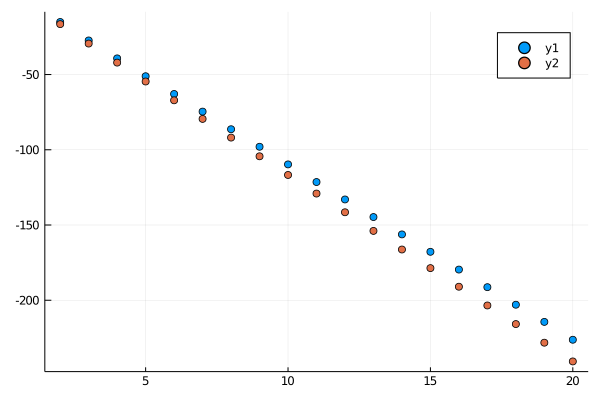

In [169]:
using Plots

plot(collect(2:20),
    log.([Ω̂.ω([1, i], 0) for i in 2:20]), 
    seriestype = :scatter)

plot!(collect(2:20),
    log.([Ω̂.ω([0, i], 0) for i in 2:20]), 
    seriestype = :scatter)

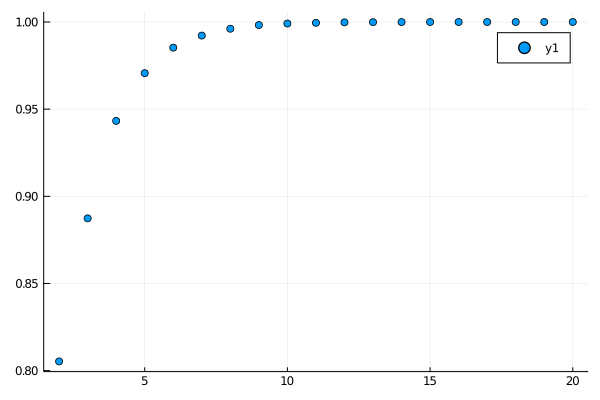

In [170]:


plot(2:20, ([Ω̂.ω([1, i], 0) / ( Ω̂.ω([0, i], 0) + Ω̂.ω([1, i], 0)) for i in 2:20]), seriestype = :scatter)